In [39]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

### Load model and data for future

In [40]:
model = XGBRegressor()
model.load_model('../models/xgboost_model.ubj')

wind = pd.read_parquet('../future_data/wind.parquet')
consumption = pd.read_parquet('../future_data/consumption.parquet')

df = wind.join(consumption).tz_localize(tz='UTC')
df.tail()


,Wind_MWh,w_lag1,w_lag2,w_lag3,Consumption_MWh,c_lag1,c_lag2,c_lag3
2022-12-31 20:00:00+00:00,1641.641724,878.0,561.0,NaN,11641.276367,11561.0,10490.0,NaN
2022-12-31 21:00:00+00:00,1566.043701,703.0,583.0,NaN,11217.675781,11497.0,10318.0,NaN
2022-12-31 22:00:00+00:00,951.898865,512.0,572.0,1597.0,10164.972656,11075.0,9914.0,9950.0
2022-12-31 23:00:00+00:00,1354.330811,463.0,538.0,1514.0,10246.028320,10724.0,9535.0,9610.0
2023-01-01 00:00:00+00:00,1078.862183,601.0,547.0,1386.0,9447.356445,10473.0,9296.0,9408.0


#### Helper function to add time series features

In [41]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [42]:
def get_recommendation(x):
    if x > 1.3:
        return '-'
    elif x < -0.7:
        return '+'
    else:
        return '0'

### Predict the future!

In [43]:
NUMBER_OF_DAYS_TO_PREDICT = 30
SMA_WINDOW = 168 # Window size for simple moving average

In [44]:
now_ceil = pd.Timestamp.now(tz='UTC').ceil(freq='H')
date_range = pd.date_range(
        start=now_ceil-timedelta(hours=SMA_WINDOW), end=now_ceil+timedelta(days=NUMBER_OF_DAYS_TO_PREDICT), freq="H")
future_df = pd.DataFrame({'datetime': date_range}).set_index('datetime')
future_df = future_df.join(df)
future_df = create_features(future_df)


In [45]:
features = ['Wind_MWh','Consumption_MWh','dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'c_lag1','c_lag2','c_lag3','w_lag1','w_lag2','w_lag3'] # These should be the same as used in modelling!!!
future_df['price'] = model.predict(future_df[features])

# Plot the price for the future!

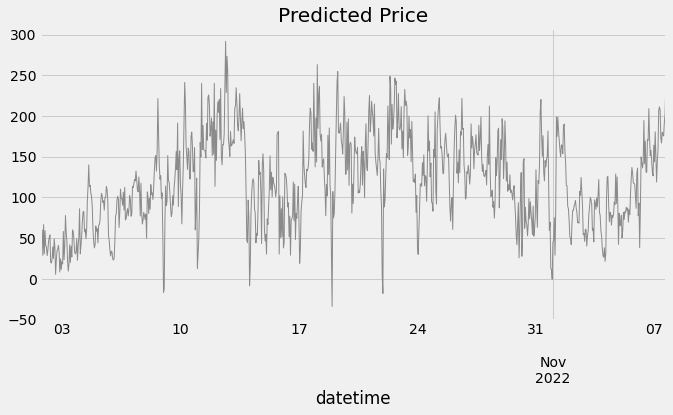

In [46]:
future_df['price'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Predicted Price')
plt.show()

### Calculate SMA and price index

In [47]:
future_df['SMA'] = future_df['price'].rolling(SMA_WINDOW).mean()
future_df['value'] = future_df['price'] / future_df['SMA']
future_df['recommendation'] = future_df['value'].apply(
    get_recommendation)
RETURNED_FEATURES = ['value', 'recommendation']
future_df = future_df[now_ceil+timedelta(hours=SMA_WINDOW):][RETURNED_FEATURES].reset_index()
future_df

,datetime,value,recommendation
0,2022-10-15 17:00:00+00:00,1.282263,0
1,2022-10-15 18:00:00+00:00,1.301138,-
2,2022-10-15 19:00:00+00:00,1.305223,-
3,2022-10-15 20:00:00+00:00,0.221053,0
4,2022-10-15 21:00:00+00:00,0.738744,0
...,...,...,...
548,2022-11-07 13:00:00+00:00,1.677884,-
549,2022-11-07 14:00:00+00:00,1.836063,-
550,2022-11-07 15:00:00+00:00,1.921821,-
551,2022-11-07 16:00:00+00:00,2.239847,-
